In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import mne

import random 
import re
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [17]:
DB_PATH = './db/v1.5.1/'

channel_keeps = ['EEG F8-REF', 'EEG T5-REF', 'EEG F7-REF', 'EEG FP1-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG FZ-REF', 'EEG T4-REF', 'EEG O2-REF', 'EEG F3-REF', 'EEG T6-REF', 'EEG CZ-REF', 'EEG FP2-REF', 'EEG O1-REF', 'EEG C4-REF', 'EEG T3-REF', 'EEG PZ-REF', 'EEG F4-REF', 'EEG C3-REF']


In [2]:
# Load the arrays

with open('datasets/X_train_10.pkl', 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/y_train_10.pkl', 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/X_test_10.pkl', 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)
    pickle_file.close()
    
with open('datasets/y_test_10.pkl', 'rb') as pickle_file:
    y_test = pickle.load(pickle_file)
    pickle_file.close()
    

In [3]:
# Define the length of each sample

WINDOW_LENGTH = 10 # in seconds 
WINDOW_LENGTH_MS = WINDOW_LENGTH * 250

In [4]:
# Shuffle the data to prevent similar samples getting memorized together

train_indices = tf.range(start=0, limit=tf.shape(X_train)[0], dtype=tf.int32)
test_indices = tf.range(start=0, limit=tf.shape(X_test)[0], dtype=tf.int32)

train_idx = tf.random.shuffle(train_indices)
X_train = tf.gather(X_train, train_idx)
y_train = tf.gather(y_train, train_idx)

test_idx = tf.random.shuffle(test_indices)
X_test = tf.gather(X_test, test_idx)
y_test = tf.gather(y_test, test_idx)

In [5]:
# Define the layers of the model

model = tf.keras.models.Sequential([
    # 100 unit GRU layer
    tf.keras.layers.GRU(100, activation='tanh', input_shape=(WINDOW_LENGTH_MS, 19), return_sequences=True),
    # Add a dropout rate of 0.2
    tf.keras.layers.Dropout(0.5),
    # 100 unit GRU layer
    tf.keras.layers.GRU(100, activation='tanh'),
    # Add a dropout rate of 0.2
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 'interictal' and 1 for 'preictal'
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2500, 100)         36300     
_________________________________________________________________
dropout (Dropout)            (None, 2500, 100)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 97,001
Trainable params: 97,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Save the model under certain conditions

callback_checkpoint = ModelCheckpoint(filepath='Best_Model.ckpt',
                                      monitor='val_accuracy',
                                      verbose=0,
                                      save_weights_only=True,
                                      save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_accuracy', 
                                            min_delta=0, 
                                            patience=3, 
                                            verbose=1,
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=False)

In [7]:
# Compile the model

model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

In [8]:
# Train for 20 epochs max

EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(X_train, 
                    y_train,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_split=0.06,
                    callbacks=[callback_checkpoint, callback_early_stopping],
                    verbose=1)

model.save('GRU10Sec.h5')

Epoch 1/20
125/125 [==============================] - 554s 4s/step - loss: 0.7370 - accuracy: 0.5545 - auc: 0.5517 - recall: 0.4189 - precision: 0.4664 - val_loss: 0.5729 - val_accuracy: 0.7126 - val_auc: 0.7560 - val_recall: 0.4151 - val_precision: 0.8000
Epoch 2/20
125/125 [==============================] - 662s 5s/step - loss: 0.6116 - accuracy: 0.6618 - auc: 0.7003 - recall: 0.4734 - precision: 0.5980 - val_loss: 0.5656 - val_accuracy: 0.7165 - val_auc: 0.7741 - val_recall: 0.6981 - val_precision: 0.6491
Epoch 3/20
125/125 [==============================] - 644s 5s/step - loss: 0.5513 - accuracy: 0.7176 - auc: 0.7776 - recall: 0.6025 - precision: 0.6806 - val_loss: 0.5322 - val_accuracy: 0.6890 - val_auc: 0.7937 - val_recall: 0.6038 - val_precision: 0.6337
Epoch 4/20
125/125 [==============================] - 770s 6s/step - loss: 0.4744 - accuracy: 0.7719 - auc: 0.8414 - recall: 0.6632 - precision: 0.7424 - val_loss: 0.5529 - val_accuracy: 0.7520 - val_auc: 0.8273 - val_recall: 0.5

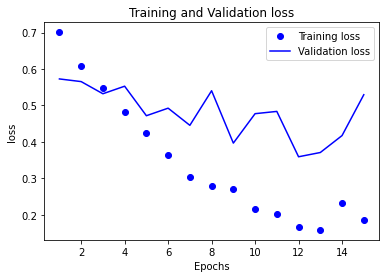

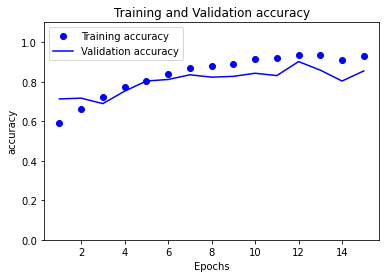

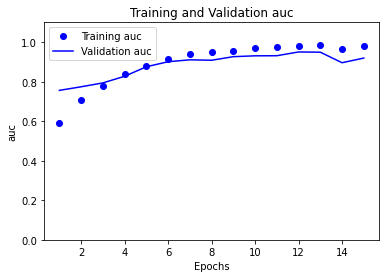

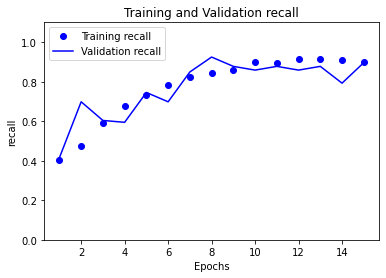

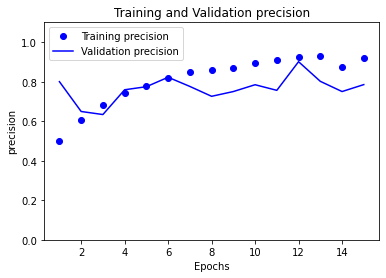

In [9]:
# Plot the progress of training

def plot_progress(history_dict):
  for key in list(history_dict.keys())[:5]:
    plt.clf() # Clears the figure
    training_values = history_dict[key] 
    val_values = history_dict['val_'+key]

    epochs = range(1, len(training_values) + 1)

    plt.plot(epochs, training_values, 'bo', label='Training '+key)

    plt.plot(epochs, val_values, 'b', label='Validation '+key)

    if key != 'loss':
      plt.ylim([0.,1.1])

    plt.title('Training and Validation '+key)
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.legend()
    plt.show()
    
plot_progress(history.history)

In [76]:
# Evaluate the trained model with the test set
metrics = model.evaluate(X_test, y_test)

pd.DataFrame(metrics, index = model.metrics_names)

9/9 [==============================] - 9s 959ms/step - loss: 0.4149 - accuracy: 0.8759 - auc: 0.9319 - recall: 0.8609 - precision: 0.8390


,0
loss,0.414946
accuracy,0.875886
auc,0.931867
recall,0.860870
precision,0.838983
